## Set up dataframe with features and labels

In [2]:
import sys
sys.path.append('/Users/q616967/Library/Python/3.10/lib/python/site-packages')

In [3]:
import os
import pandas as pd
import json
import numpy as np

from sklearn.model_selection import train_test_split

In [4]:
PROJECT_DIR = "/Users/q616967/Workspace/thesis/uni/xai-thesis/"
FEATURES_DIR = os.path.join(PROJECT_DIR, "feature_extraction/featureExtraction/output/")
RESPONSES_DIR = os.path.join(PROJECT_DIR, "responses/")

In [5]:
features_df = pd.read_csv(os.path.join(FEATURES_DIR, "merged_features.csv"))

In [6]:
responses_filename = "formatted_turbo14081857_turbo1508_eval.json"

with open(os.path.join(RESPONSES_DIR, responses_filename), "r") as f:
    responses = json.load(f)

In [7]:
idx_outcome_dict = {int(idx):res_dict['outcome'] for idx, res_dict in responses.items()}

labels_df = pd.DataFrame.from_dict(idx_outcome_dict, columns=['outcome'], orient='index')

try:
    assert len(features_df) == len(labels_df)
except AssertionError:
    print("Length mismatch between features and labels")

data_df = pd.merge(features_df, labels_df, left_index=True, right_index=True)

## Explore df

- currently using all the extracted features (2150)
- general rule: 10x more instances than features

In [10]:
data_df.shape

(700, 2150)

In [11]:
# drop columns with all NaNs
data_df.dropna(axis=1, how='all', inplace=True)
data_df.shape

(700, 2150)

In [13]:
# drop all constant features
data_df = data_df.loc[:, (data_df != data_df.iloc[0]).any()]
data_df.shape

(700, 2150)

In [14]:
# find columns with catergorical values, should be none
data_df.select_dtypes(include=['object']).columns

Index([], dtype='object')

In [15]:
# see if any columns has a non-numerical value, should be only 'outcome'
data_df.select_dtypes(exclude=['int64', 'float64']).columns

Index(['outcome'], dtype='object')

In [27]:
# full data with all features
# split into train and test
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

X_train = train_df.drop(columns=['outcome'])
y_train = train_df['outcome']

X_test = test_df.drop(columns=['outcome'])
y_test = test_df['outcome']

## Pre-processing for Feature Selection

- scale features
- drop constant features after split

In [28]:
# standardise the values of the features (to the same range/scale)
from sklearn.preprocessing import StandardScaler

features = X_train.columns
scaler = StandardScaler()

X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

For some features, almost all the values are zeros (or constant). I removed all the features with constant value from data_df (before the split), but after the split there can be features in X_train that have constant values.

- it throws a warning
- do another step of filtering
- same idx removed from train will have to be removed from test as well


In [30]:
# features in X_train where all the values are the same - constant features
constant_features = X_train.columns[X_train.nunique() == 1]

# drop constant features from both X_train and X_test
X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape


((560, 2126), (140, 2126))

### If X_train and X_test are arrays

- this is the case if the scaler is run normally, it transforms df to array

In [102]:
# remove from array all columns that have constant values
#X_train = X_train[:, ~np.all(X_train[1:] == X_train[:-1], axis=0)]
#X_train.shape

# find indices of columns in array that have constant values instead of removing them
# (so that later I can remove by idx)
constant_idx = np.where(np.all(X_train[1:] == X_train[:-1], axis=0))[0]
constant_idx

array([  10,  256,  520,  864,  916,  957,  961,  962, 1043, 1176, 1225,
       1227, 1268, 1335, 1671, 1763, 1767, 1768, 1845, 1978, 2023, 2025,
       2066])

In [103]:
# !! removing by idx so do not run multiple times as the idx will change
# remove from array all columns that have idx in constant_idx
X_train = np.delete(X_train, constant_idx, axis=1)
X_train.shape

(560, 2126)

In [104]:
# remove constant idx columns from X_test as well
X_test = np.delete(X_test, constant_idx, axis=1)
X_test.shape


(140, 2126)

## Select K Best (sklearn)

- define k and select k features to keep (based on statistical tests)

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=100)

In [32]:
X_train_kbest = selector.fit_transform(X_train, y_train)

In [34]:
X_train_kbest.shape, type(X_train_kbest)

((560, 100), numpy.ndarray)

In [59]:
# idx of selected features
selected_idx = selector.get_support(indices=True)

# names of selected features
selected_features = X_train.columns[selected_idx]
len(selected_features)


100

In [60]:
# df with only the selected features (full data) + outcome
data_kbest = data_df[selected_features]
data_kbest = data_kbest.join(data_df['outcome'])
data_kbest.shape

(700, 101)

In [108]:
# df with only the selected features (after train/test split)
X_train_kbest = X_train[selected_features]
X_test_kbest = X_test[selected_features]
X_train_kbest.shape, X_test_kbest.shape

((560, 100), (140, 100))

In [63]:
# outcome column should not be in X_train_kbest
'outcome' in X_train_kbest.columns

False

In [62]:
# outcome column should be in data_kbest
'outcome' in data_kbest.columns

True

In [ ]:
# transform boolean values to 0/1 in outcome column
#data_df_fs['outcome'] = data_df_fs['outcome'].astype(int)

## Correlation (Pearson)

- remove features that are highly correlated to each other (keep the one that has higher correlation to the target variable)

In [69]:
def remove_collinear_features(features_df, threshold, target_name='outcome'):
    '''
    Check for collinear features (highly correlated to another feature)
    and remove the one with lower correlation to the target.

    Inputs:
        features_df: dataframe with features, which includes the target
        threshold: correlation threshold above which to remove features
        target_name: name of the target column
    
    Returns a df which excludes the collinear features.
    '''

    corr_matrix = features_df.corr()
    to_drop = []

    '''Iterate through the correlation matrix and compare correlations'''
    for i in range(len(corr_matrix.columns) - 1):
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            '''If correlation exceeds the threshold'''
            if val >= threshold:
                feature1 = col.values[0]
                feature2 = row.values[0]

                if feature1 in to_drop or feature2 in to_drop:
                    continue
                
                correlation = round(val[0][0], 2)

                #print(f'''{feature1} | {feature2} | {correlation}\n
                #    -> Removing the feature with lower correlation to target:''')


                '''Calculate correlations with outcome for both features'''
                corr_f1_y = features_df[feature1].corr(features_df[target_name])
                corr_f2_y = features_df[feature2].corr(features_df[target_name])

                '''Drop the feature with lower correlation to outcome'''
                if corr_f1_y <= corr_f2_y:
                    to_drop.append(feature1)
                    #print(f"\t{feature1}")
                else:
                    to_drop.append(feature2)
                    #print(f"\t{feature2}")
                
    print(f"Removing {len(to_drop)} features: {to_drop}")
    features_df = features_df.drop(columns=to_drop)

    return features_df

In [70]:
data_kbest_nocoll = remove_collinear_features(data_kbest, 0.5)
len(data_kbest_nocoll.columns)

Removing 65 features: ['Exprsv_GI', 'Sklasth_Lasswell', 'Name_GI', 'Amusement_GALC', 'Disgust_GALC_neg_3', 'Lust_GALC_neg_3', 'Submit_GI_neg_3', 'Socrel_GI', 'Numb_GI_neg_3', 'Ord_GI_neg_3', 'Space_GI', 'Name_GI_neg_3', 'Affloss_Lasswell_neg_3', 'Skltot_Lasswell', 'Sklasth_Lasswell_neg_3', 'Nation_Lasswell', 'Negaff_Lasswell', 'Timespc_Lasswell', 'Affloss_Lasswell', 'Disgust_GALC_nouns', 'attention_nouns', 'Anger_GALC_nouns', 'Nation_Lasswell_nouns', 'Amusement_GALC_verbs', 'Submit_GI', 'Work_GI_verbs', 'Sklasth_Lasswell_verbs', 'aptitude_adverbs', 'Begin_GI_adverbs', 'Ord_GI', 'Ord_GI_adverbs', 'Pos_GI_adverbs', 'Rel_GI_adverbs', 'Timespc_Lasswell_adverbs', 'Anger_GALC_nouns_neg_3', 'Disgust_GALC_nouns_neg_3', 'Pleasure/Enjoyment_GALC_nouns', 'attention_nouns_neg_3', 'aptitude_nouns_neg_3', 'polarity_nouns_neg_3', 'Virtue_GI_nouns', 'Socrel_GI_nouns_neg_3', 'Causal_GI_nouns_neg_3', 'Powloss_Lasswell_nouns_neg_3', 'Affloss_Lasswell_nouns_neg_3', 'Nation_Lasswell_nouns_neg_3', 'Amusemen

36

### Correlation matrix

- the collinear features have been removed -> now we don't have correlations above the threshold

In [71]:
corr_df = data_kbest_nocoll.corr()

<Axes: >

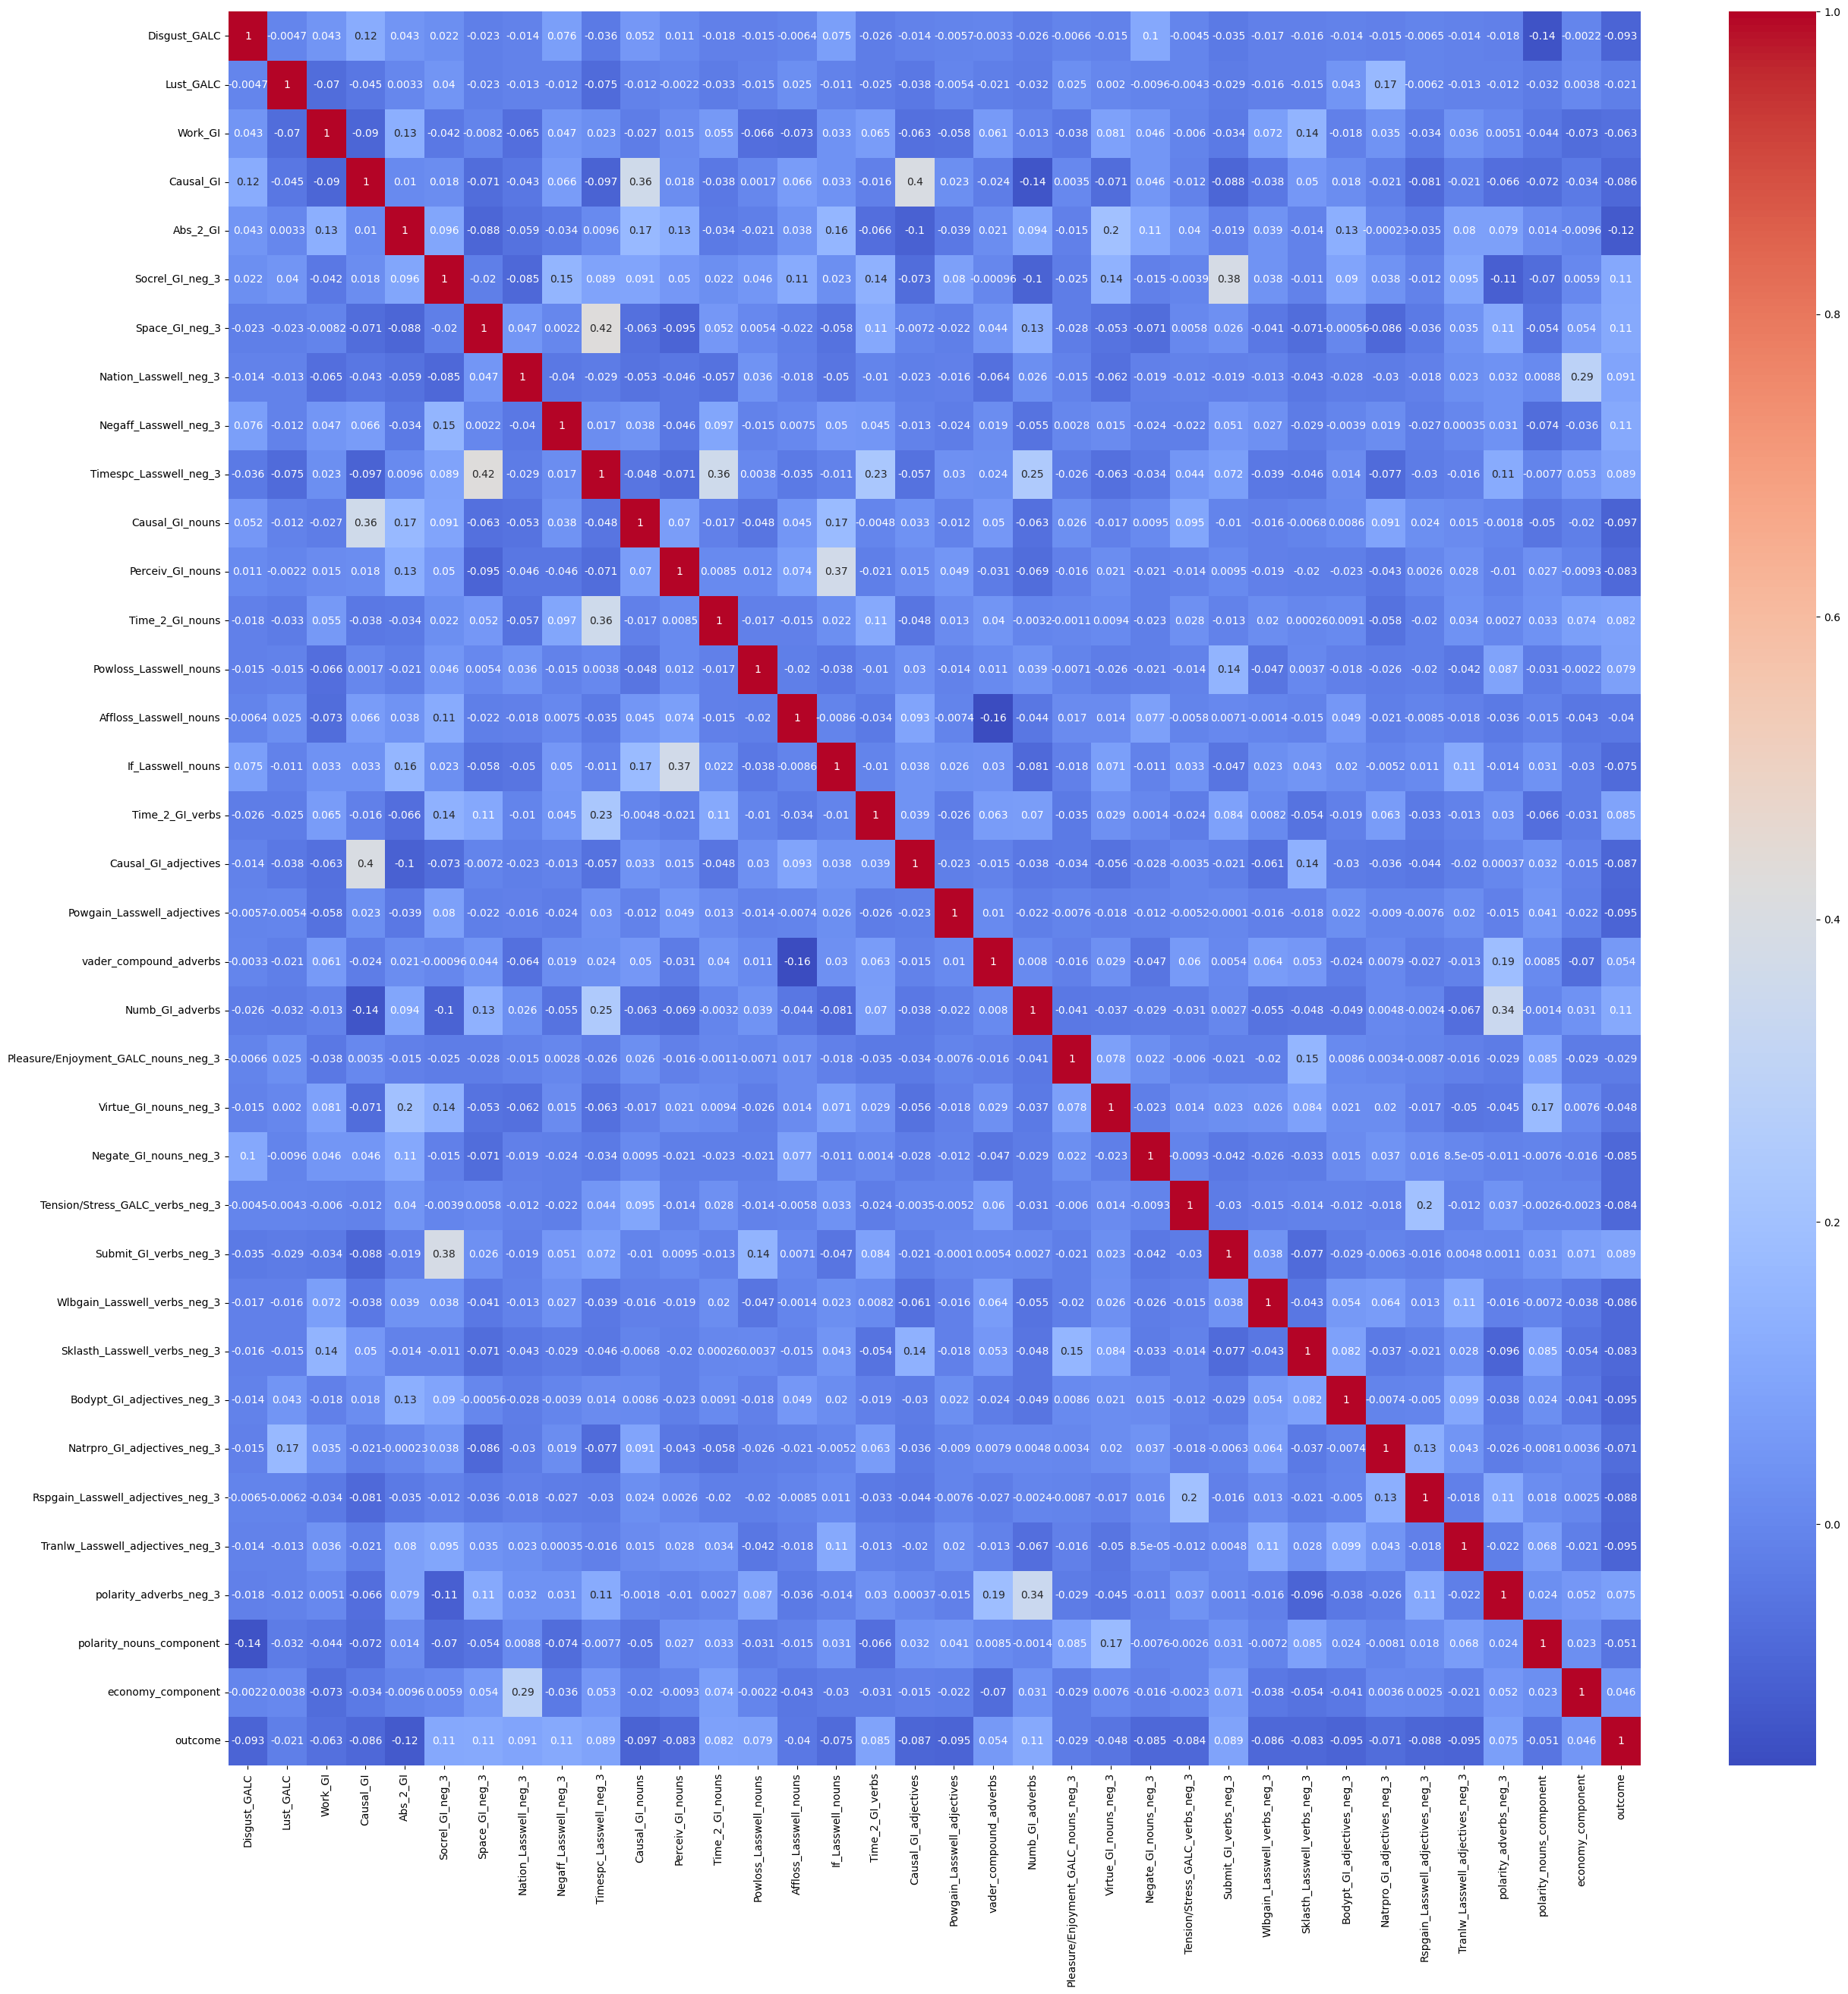

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')

## Prediction-based Feature Selection

Figure out which features are important based on how they affect performance

In [74]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=1)

In [109]:
X_train_kbest.shape, y_train.shape

((560, 100), (560,))

### Forward Sequential Selection

In [78]:
from sklearn.feature_selection import SequentialFeatureSelector

'''
n_features_to_select='auto' or int
if 'auto', and tol is None (default), the number of features to select is half the number of features.
if tol is float, then features are selected while the score change does not exceed tol
'''

sfs = SequentialFeatureSelector(model,
                                tol=None,
                                direction='forward', 
                                n_features_to_select='auto',
                                scoring='accuracy',
                                cv=5)
sfs.fit(X_train_kbest, y_train) # using the features selected by SelectKBest, otherwise it takes too long

SequentialFeatureSelector(estimator=LogisticRegression(random_state=1),
                          scoring='accuracy')

In [81]:
'''Features to keep, according to forward sequential selection'''
forward_feats = sfs.get_feature_names_out()
len(forward_feats), forward_feats[:10]

(50,
 array(['Disgust_GALC', 'Lust_GALC', 'Exprsv_GI', 'Ord_GI', 'Name_GI',
        'Affloss_Lasswell', 'Sklasth_Lasswell', 'Disgust_GALC_neg_3',
        'Lust_GALC_neg_3', 'Name_GI_neg_3'], dtype=object))

### Backwards Selection

In [82]:
sfs_back = SequentialFeatureSelector(model,
                                    tol=None,
                                    direction='backward', 
                                    n_features_to_select='auto',
                                    scoring='accuracy',
                                    cv=5)
sfs_back.fit(X_train_kbest, y_train)

SequentialFeatureSelector(direction='backward',
                          estimator=LogisticRegression(random_state=1),
                          scoring='accuracy')

In [83]:
backward_feats = sfs_back.get_feature_names_out()
len(backward_feats), backward_feats[:10]

(50,
 array(['Exprsv_GI', 'Causal_GI', 'Abs_2_GI', 'Name_GI',
        'Sklasth_Lasswell', 'Nation_Lasswell', 'Negaff_Lasswell',
        'Timespc_Lasswell', 'Lust_GALC_neg_3', 'Submit_GI_neg_3'],
       dtype=object))

Idea: select features that are in both forward and backward selection (?)
- a kind of ensemble of feature selection methods

In [92]:
ensemble_feats = list(set(forward_feats) & set(backward_feats)) # intersection
len(ensemble_feats), ensemble_feats[:10]

(27,
 ['Lust_GALC_neg_3',
  'Timespc_Lasswell_adverbs',
  'Powgain_Lasswell_adjectives',
  'Tension/Stress_GALC_verbs_neg_3',
  'Natrpro_GI_adjectives_neg_3',
  'Rel_GI_adverbs',
  'polarity_adverbs_neg_3',
  'Exprsv_GI',
  'Negaff_Lasswell_neg_3',
  'attention_nouns_neg_3'])

#### Using statsmodels (backward elimination)

Try using statsmodels model because sklearn does not allow getting pvalues (which we need to calculate if a feature is to be elimitated)

In [110]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train_kbest)

model = sm.OLS(y_train, X_train_sm).fit(maxiter=200)

In [111]:
X_train_sm.shape # with const column

(560, 101)

In [112]:
y_train.shape

(560,)

In [150]:
features = list(X_train_kbest.columns) #no const
num_features = len(features)
max_pvalue = 1


while len(features) > 0:

    X = X_train_kbest[features]
    X = sm.add_constant(X)
    model = sm.OLS(y_train, X).fit(maxiter=200)

    pvalues = pd.Series(model.pvalues.values[1:], index=features)

    max_pvalue = pvalues.max()
    max_pvalue_feature_name = pvalues.idxmax()
    max_pvalue_feature_idx = pvalues.argmax()

    if max_pvalue > 0.05:
        features.remove(max_pvalue_feature_name)
    else:
        break

len(features), features[:10]

(19,
 ['Lust_GALC',
  'Disgust_GALC_neg_3',
  'Socrel_GI_neg_3',
  'Space_GI_neg_3',
  'Negaff_Lasswell_neg_3',
  'Virtue_GI_nouns',
  'Causal_GI_adjectives',
  'Rspgain_Lasswell_adjectives',
  'aptitude_adverbs',
  'polarity_nouns_neg_3'])

### Recursive Feature Elimination

In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

'''
n_features_to_selectint or float, default=None
    If None, half of the features are selected. 
    If integer, the parameter is the absolute number of features to select. 
    If float between 0 and 1, it is the fraction of features to select.   
step: features to remove at each iteration. Default is 1.
'''

model = LogisticRegression(random_state=1, max_iter=200)
RFE_selector = RFE(estimator=model, 
                    n_features_to_select=100, 
                    step=1,
                    verbose=0)

In [152]:
X_train.shape, y_train.shape

((560, 2126), (560,))

In [157]:
X_train_rfe = RFE_selector.fit_transform(X_train, y_train)

In [158]:
X_test_rfe = RFE_selector.transform(X_test)

In [162]:
rfe_features = RFE_selector.get_feature_names_out()
len(rfe_features), rfe_features[:10]

(100,
 array(['Joy_EmoLex', 'hu_liu_prop', 'Emot_GI', 'Ritual_GI', 'Color_GI',
        'Iav_GI', 'Rcends_Lasswell', 'Sadness_GALC_neg_3',
        'Joy_EmoLex_neg_3', 'Dominance_neg_3'], dtype=object))